## Assignment 1 -- Solution

In [1]:
import numpy as np
from sklearn.datasets import load_iris, load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy.stats import multivariate_normal as mvn
from matplotlib import pyplot as plt

### Problem 1

In [2]:
data = load_iris()
print(data.feature_names)
print(data.target_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


In [3]:
# Store features 2 (petal length) and 3 (petal width) in a matrix X.
# Store the target labels (0, 1, 2) in the vector y.

X = data.data[:, 2:]
y = data.target

# Split data into training and testing sets.

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

# Compute the relative proportions (prior probabilities) of the three species of iris in the training set.

classes = np.unique(y) # 0, 1, 2
p_y = np.array([np.sum(y_tr == i) for i in classes])/len(y_tr)

for (y, p) in zip(classes, p_y):
    print(f"class {y}, proportion {p:.2}")

class 0, proportion 0.33
class 1, proportion 0.33
class 2, proportion 0.35


In [4]:
# Subdivide the training set according to class label.

X_tr_y = [X_tr[y_tr == k, :] for k in classes]

# Compute the class conditional means and covariances using the training data.

means = [np.mean(x, axis=0) for x in X_tr_y]
covs = [np.cov(x.T) for x in X_tr_y]

for i, (mean, cov) in enumerate(zip(means, covs)):
    print(f"class {i}:\n-------\nmean = {mean}\ncov = {cov}\n")

class 0:
-------
mean = [1.47435897 0.24871795]
cov = [[0.03248313 0.00601889]
 [0.00601889 0.01098516]]

class 1:
-------
mean = [4.28461538 1.32820513]
cov = [[0.2034413  0.07676113]
 [0.07676113 0.0431309 ]]

class 2:
-------
mean = [5.48809524 2.02619048]
cov = [[0.28107433 0.04934379]
 [0.04934379 0.0663705 ]]



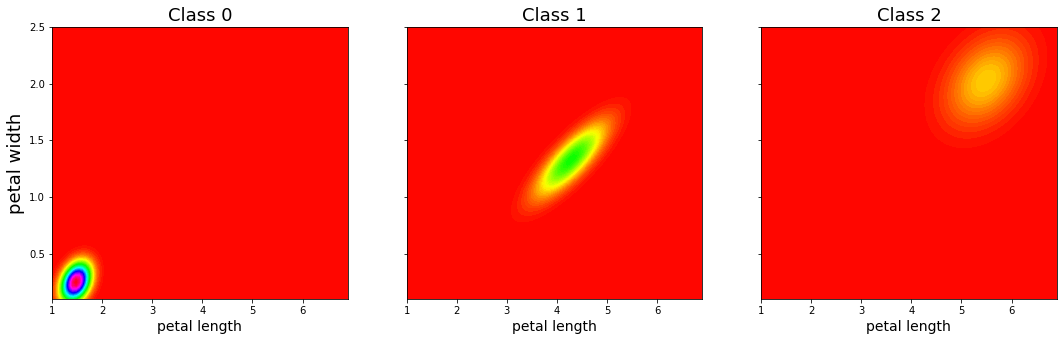

In [5]:
# Plot the class densities.

lmin, wmin = np.min(X, axis=0)
lmax, wmax = np.max(X, axis=0)
l = np.linspace(lmin, lmax, 100)
w = np.linspace(wmin, wmax, 100)
L, W = np.meshgrid(l, w)
LW = np.stack((L, W), axis=-1)
pdfs = [mvn.pdf(LW, mean=mean, cov=cov) for (mean, cov) in zip(means, covs)];

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
levels = np.linspace(np.min(pdfs), np.max(pdfs), 100)
axes[0].set_ylabel("petal width", fontsize=18)
for i, (pdf, axis) in enumerate(zip(pdfs, axes)):
    axis.contourf(L, W, pdf, levels=levels, cmap="hsv");
    axis.set_title(f"Class {i}", fontsize=18)
    axis.set_xlabel("petal length", fontsize=14)

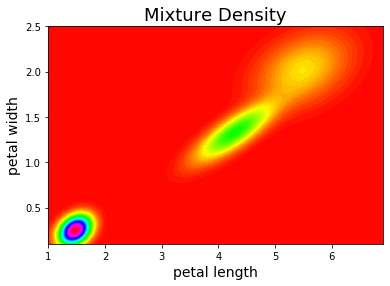

In [6]:
pdf = sum([p*pdf for (p, pdf) in zip(p_y, pdfs)])

# Plot the mixture densities.
levels = np.linspace(np.min(pdf), np.max(pdf), 100)
plt.contourf(L, W, pdf, levels=levels, cmap="hsv")
plt.title("Mixture Density", fontsize=18)
plt.xlabel("petal length", fontsize=14)
plt.ylabel("petal width", fontsize=14);

In [7]:
# Compute class conditional likelihoods of the test data.

p_X_y = np.array([mvn.pdf(X_te, mean=mean, cov=cov) for (mean, cov) in zip(means, covs)]).T

# Compute the marginal likelihoods of the data.

p_X = np.sum(p_X_y*p_y, axis=1).reshape(-1, 1)

# Compute the posterior probabilities of the classes given the data using Bayes' Theorem.

p_y_X = (p_X_y*p_y)/p_X

# Check: The posterior probabilities for a given data point should add up to 1.

np.all(np.sum(p_y_X, axis=1) - 1 < 1e-10) # Should be true.

# Predict class labels:

y_pr = np.argmax(p_y_X, axis=1)

# Prediction accuracy:

acc = accuracy_score(y_te, y_pr)
print(f"test accuracy: {acc:.4}")

test accuracy: 1.0


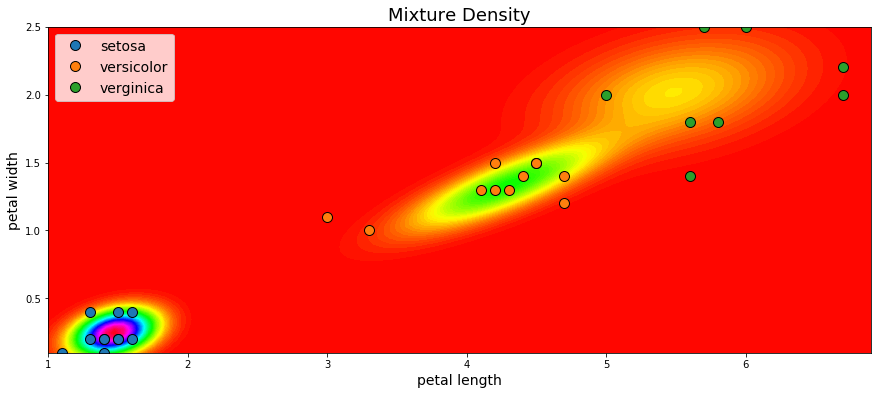

In [8]:
plt.figure(figsize=((lmax - lmin)/(wmax - wmin)*6, 6))
plt.contourf(L, W, pdf, levels=levels, cmap="hsv");
plt.xlabel("petal length", fontsize=14)
plt.ylabel("petal width", fontsize=14)
plt.title("Mixture Density", fontsize=18);

plt.plot(*X_te[y_pr == 0].T, 'o', ms=10, mec='k', label="setosa")
plt.plot(*X_te[y_pr == 1].T, 'o', ms=10, mec='k', label="versicolor")
plt.plot(*X_te[y_pr == 2].T, 'o', ms=10, mec='k', label="verginica")
plt.legend(fontsize=14);

### Problem 2

In [9]:
X, y = load_diabetes(return_X_y=True)

In [10]:
TEST_SIZE = 0.2

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

M = LinearRegression()
M.fit(X_tr, y_tr)
y_pr = M.predict(X_te)
test_mse = mean_squared_error(y_te, y_pr)
print(f"test_mse = {test_mse}")

test_mse = 2900.1732878832318


In [11]:
# We can also estimate prediction error using cross validation.

score = -cross_val_score(M, X, y, cv=10, scoring="neg_mean_squared_error").mean()
print(f"cv score = {score}")

# Note: If you're using cross-validation for model selection purposes, you should apply it to the training data.

cv score = 3000.3810328390514


In [12]:
# Use cross validation to choose the k parameter for k-nearest neighbors.

scores = []
ks = np.arange(1, 21)
for k in ks:
    M = KNeighborsRegressor(n_neighbors=k)
    score = -cross_val_score(M, X_tr, y_tr, cv=10, scoring="neg_mean_squared_error").mean()
    scores.append(score)
k_opt = ks[np.argmin(scores)]
print(f"k_opt = {k_opt}")

k_opt = 15


In [13]:
# Now retrain using k=k_opt.

M = KNeighborsRegressor(n_neighbors=k_opt)
M.fit(X_tr, y_tr)
y_pr = M.predict(X_te)
test_mse = mean_squared_error(y_te, y_pr)
print(f"test_mse = {test_mse}")

test_mse = 3081.7412234706626


In [14]:
# Let's play with some more KNeighborRegressor's parameters.

ks = np.arange(1, 21)
params = [(k, w) for k in ks for w in ["uniform", "distance"]]
scores = []
for (k, w) in params:
    M = KNeighborsRegressor(n_neighbors=k, weights=w)
    score = -cross_val_score(M, X_tr, y_tr, cv=10, scoring="neg_mean_squared_error").mean()
    scores.append(score)
k_opt, w_opt = params[np.argmin(scores)]
print(f"k_opt = {k_opt}, w_opt = {w_opt}")

k_opt = 15, w_opt = distance


In [15]:
# Now retrain using k=k_opt and w=w_opt

M = KNeighborsRegressor(n_neighbors=k_opt, weights=w_opt)
M.fit(X_tr, y_tr)
y_pr = M.predict(X_te)
test_mse = mean_squared_error(y_te, y_pr)
print(f"test_mse = {test_mse}")

test_mse = 3009.5381008280688


The error estimates are all roughly comparable.
Linear regression model performing as well as the much more flexible k-nearest neighbors suggests that the former accurately reflects the structure of the data set.